In [1]:
!pip install insightface onnxruntime-gpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp312-cp312-linux_x86_64.whl size=1071487 sha256=e85ef029571e13f0b5d768f052a65d6da6d519b626a66028a77bf85405250e5a
  Stored in directory: /root/.cache/pip/wheels/73/3c/e2/6d4815e8a8b33a2006554d65ce0d1f973e768f4c7a222fa675
Successfully built insightface


In [2]:
from insightface.app import FaceAnalysis
import numpy as np
import cv2


In [3]:
app = FaceAnalysis(
    name="buffalo_l",          # detector + ArcFace
    providers=["CUDAExecutionProvider"]
)
app.prepare(ctx_id=0, det_size=(640, 640))


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 92852.16KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

In [ ]:
image_paths = [
    "images1.jpg",
    "images2.jpg",
    "images3.jpg",
    "images4.jpg",
    "images5.png",
    "images6.png",
    "images7.png",
]

In [20]:
faces = []
embeddings = []

for p in image_paths:
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    detected = app.get(img)
    for f in detected:
        x1, y1, x2, y2 = map(int, f.bbox)
        crop = img[y1:y2, x1:x2]

        if crop.size == 0:
            continue

        faces.append(crop)
        embeddings.append(f.embedding)


In [21]:
embeddings = np.vstack(embeddings)
N = len(faces)


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(embeddings)


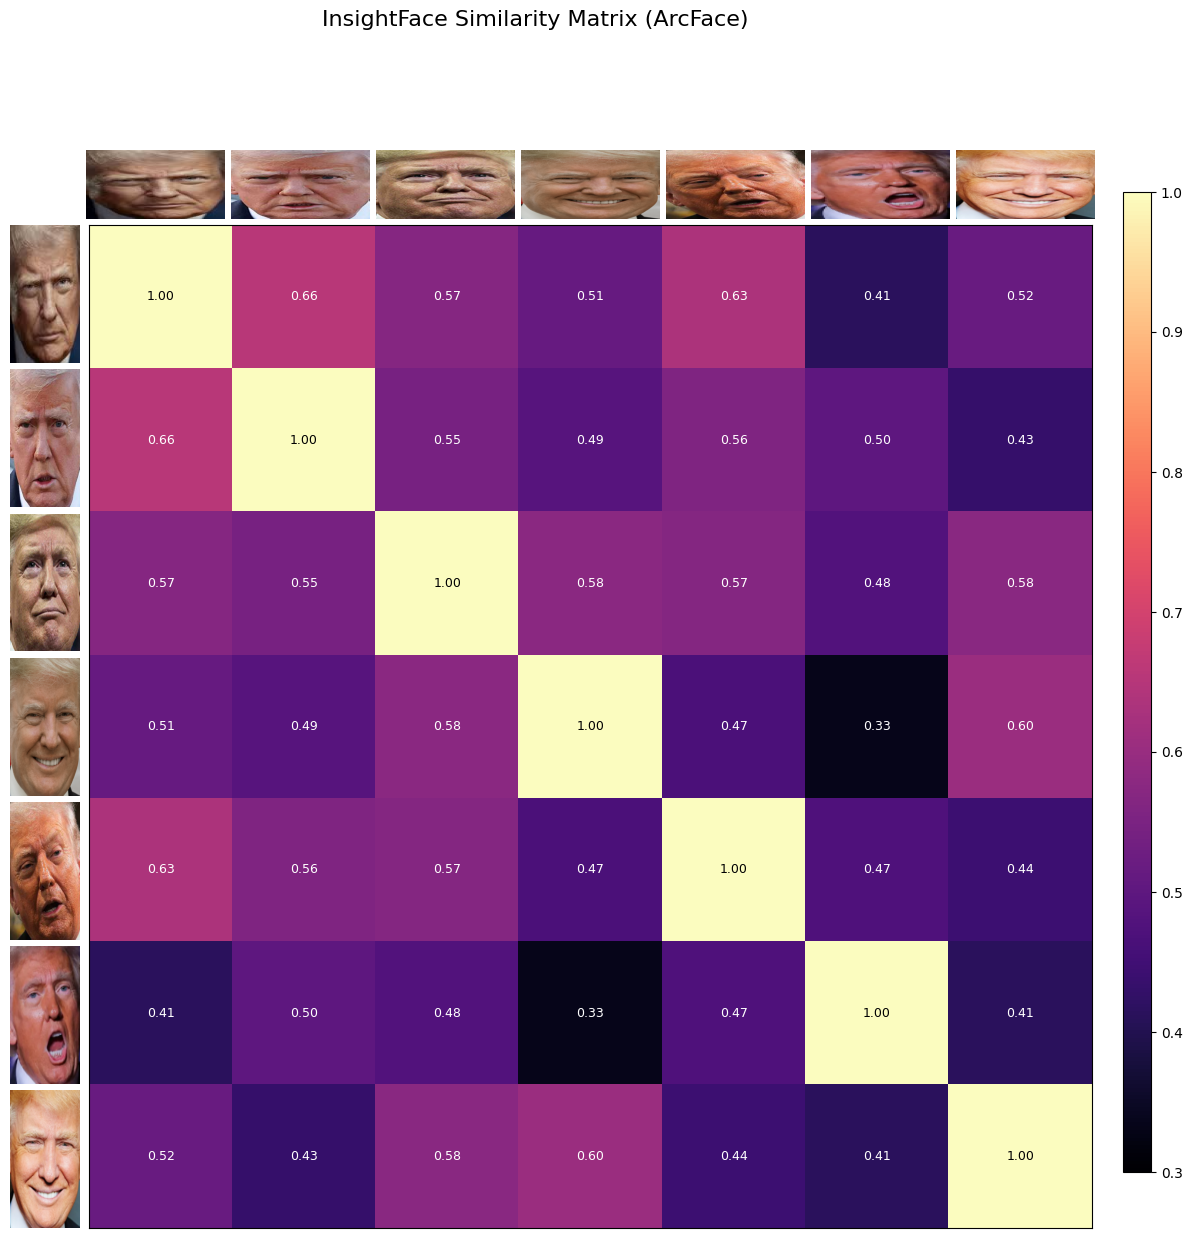

In [26]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 14))
gs = GridSpec(
    nrows=N + 1,
    ncols=N + 1,
    width_ratios=[2.5] + [5]*N,
    height_ratios=[2.5] + [5]*N,
    wspace=0.05,
    hspace=0.05
)

# empty corner
ax = fig.add_subplot(gs[0, 0])
ax.axis("off")

# column labels
for j in range(N):
    ax = fig.add_subplot(gs[0, j + 1])
    ax.imshow(faces[j], aspect="auto")
    ax.axis("off")

# row labels
for i in range(N):
    ax = fig.add_subplot(gs[i + 1, 0])
    ax.imshow(faces[i], aspect="auto")
    ax.axis("off")

# similarity heatmap
axm = fig.add_subplot(gs[1:, 1:])
im = axm.imshow(sim_matrix, cmap="magma", vmin=0.3, vmax=1.0)
axm.set_xticks([])
axm.set_yticks([])

for i in range(N):
    for j in range(N):
        axm.text(
            j, i,
            f"{sim_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if sim_matrix[i, j] < 0.7 else "black",
            fontsize=9
        )

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(im, cax=cax)
plt.suptitle("InsightFace Similarity Matrix (ArcFace)", fontsize=16)
plt.show()


### What about different peoples

In [27]:
image_paths = [
    "images5.png",
    "images6.png",
    "images7.png",
    "other1.png",
    "other2.png",
    "other3.png",
    "other4.png",
]

In [28]:
faces = []
embeddings = []

for p in image_paths:
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    detected = app.get(img)
    for f in detected:
        x1, y1, x2, y2 = map(int, f.bbox)
        crop = img[y1:y2, x1:x2]

        if crop.size == 0:
            continue

        faces.append(crop)
        embeddings.append(f.embedding)


In [29]:
embeddings = np.vstack(embeddings)
N = len(faces)


In [30]:
sim_matrix = cosine_similarity(embeddings)

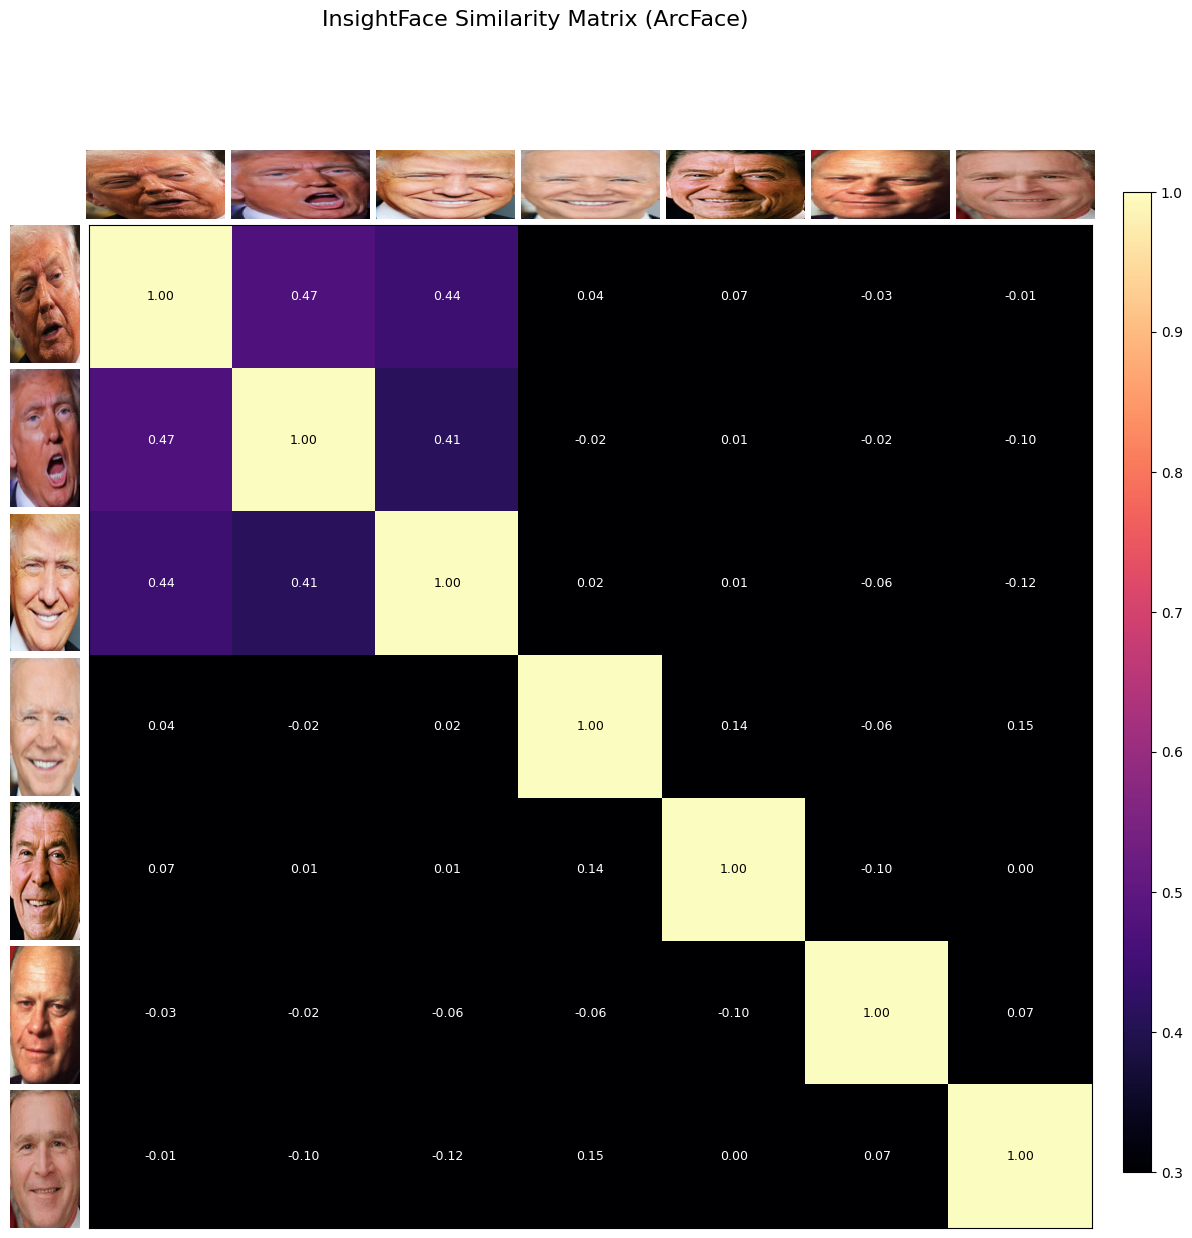

In [31]:

fig = plt.figure(figsize=(14, 14))
gs = GridSpec(
    nrows=N + 1,
    ncols=N + 1,
    width_ratios=[2.5] + [5]*N,
    height_ratios=[2.5] + [5]*N,
    wspace=0.05,
    hspace=0.05
)

# empty corner
ax = fig.add_subplot(gs[0, 0])
ax.axis("off")

# column labels
for j in range(N):
    ax = fig.add_subplot(gs[0, j + 1])
    ax.imshow(faces[j], aspect="auto")
    ax.axis("off")

# row labels
for i in range(N):
    ax = fig.add_subplot(gs[i + 1, 0])
    ax.imshow(faces[i], aspect="auto")
    ax.axis("off")

# similarity heatmap
axm = fig.add_subplot(gs[1:, 1:])
im = axm.imshow(sim_matrix, cmap="magma", vmin=0.3, vmax=1.0)
axm.set_xticks([])
axm.set_yticks([])

for i in range(N):
    for j in range(N):
        axm.text(
            j, i,
            f"{sim_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if sim_matrix[i, j] < 0.7 else "black",
            fontsize=9
        )

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(im, cax=cax)
plt.suptitle("InsightFace Similarity Matrix (ArcFace)", fontsize=16)
plt.show()
